In [40]:
from typing import Dict

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [2]:
project_path = Path.cwd().parent
mnist_path = project_path/'data/mnist'

## Prepare the dataset and dataloader for training

In [3]:
train_dataset = MNIST(root=mnist_path, download=False, transform=transforms.Compose([
    ToTensor(),
    lambda x: (x*4).int(),
    lambda x: x.float()/4,
]))
test_dataset = MNIST(root=mnist_path, train=False, transform=transforms.Compose([
    ToTensor(),
    lambda x: (x*4).int(),
    lambda x: x.float()/4,
]))

Inspecting the data

torch.Size([28, 28])
Unique values = tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])


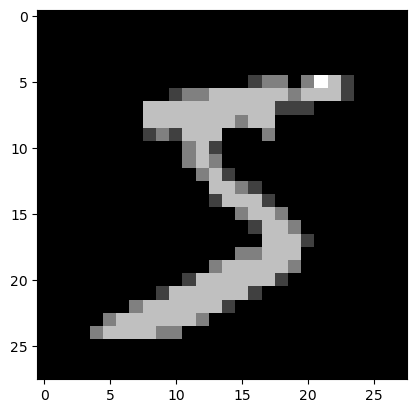

In [48]:
im = train_dataset[0][0][0]
print(im.shape)
print(f"Unique values = {im.unique()}")
plt.imshow(im, cmap='gray')

Preparing training and validation data for training

In [22]:
torch.manual_seed(43)
val_size = 5000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

batch_size = 32

train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size * 2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size * 2, pin_memory=True)


Get if device is GPU or CPU. Bring data onto the device

In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, data_loader, device):
        self.dl = data_loader
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [30]:
for x, y in train_loader:
    print(x.shape, y.shape)
    print(x.unique())
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])
tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000], device='cuda:0')


## Prepare the CNN model (2 conv layers + 1 linear layer)

In [42]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    """
    PytorchLightining style
    """
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch) -> Dict:
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs) -> Dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result) -> None:
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))


class MNISTConvModel(ImageClassificationBase):
    """
    2 conv layers + 1 linear layer
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, 5, stride=(2, 2),
                               padding=0, bias=True)

        self.conv2 = nn.Conv2d(5, 50, 5, stride=(2, 2),
                               padding=0, bias=True)
        self.fc1 = nn.Linear(800, 10, bias=True)

    def forward(self, xb):
        out = self.conv1(xb)
        out = out * out  # first square
        out = self.conv2(out)
        out = out.reshape(out.shape[0], -1)
        out = out * out  # second square
        out = self.fc1(out)

        return out


In [43]:
model = to_device(MNISTConvModel(), device)
model

MNISTConvModel(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(5, 50, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)

## Train and evaluate

In [45]:
def evaluate(model, val_loader) -> Dict:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, 
        train_loader, val_loader, test_loader, 
        file_name, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    high_acc = 0.98
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

        if epoch >= 2:
            eval_dict = evaluate(model, test_loader)
            print(str(epoch) + "\t" + str(eval_dict))
            if eval_dict['val_acc'] > high_acc:
                high_acc = eval_dict['val_acc']
                torch.save(model.state_dict(), file_name)
                print("Saved")

    return history


In [46]:
history = [evaluate(model, val_loader)]
savefile_name = "hcnn_mnist_plain"
history += fit(epochs=150, lr=0.001, model=model, 
               train_loader=train_loader, 
               val_loader=val_loader, test_loader=test_loader, 
               file_name=str(savefile_name + ".pth"), 
               opt_func=torch.optim.Adam)


Epoch [1], val_loss: 0.1171, val_acc: 0.9666
Epoch [2], val_loss: 0.0896, val_acc: 0.9707
Epoch [3], val_loss: 0.0663, val_acc: 0.9788
2	{'val_loss': 0.06194232776761055, 'val_acc': 0.9809912443161011}
Saved
Epoch [4], val_loss: 0.0680, val_acc: 0.9802
3	{'val_loss': 0.059880662709474564, 'val_acc': 0.9809912443161011}
Epoch [5], val_loss: 0.0676, val_acc: 0.9796
4	{'val_loss': 0.05957421287894249, 'val_acc': 0.9831807613372803}
Saved
Epoch [6], val_loss: 0.0554, val_acc: 0.9822
5	{'val_loss': 0.0483112707734108, 'val_acc': 0.9853702187538147}
Saved
Epoch [7], val_loss: 0.0721, val_acc: 0.9798
6	{'val_loss': 0.056040626019239426, 'val_acc': 0.9833797812461853}
Epoch [8], val_loss: 0.0654, val_acc: 0.9816
7	{'val_loss': 0.051207542419433594, 'val_acc': 0.9847730994224548}
Epoch [9], val_loss: 0.0652, val_acc: 0.9848
8	{'val_loss': 0.0532069131731987, 'val_acc': 0.9853702187538147}
Epoch [10], val_loss: 0.0751, val_acc: 0.9804
9	{'val_loss': 0.06918980181217194, 'val_acc': 0.982384562492

Final evaluation on the test dataset

In [47]:
print(evaluate(model, test_loader))


{'val_loss': 0.251384973526001, 'val_acc': 0.9829816818237305}
